In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
movies = pd.read_csv("movies.csv")
credits = pd.read_csv("credits.csv")

In [3]:
df = movies.merge(credits,on="title")


In [4]:
#EDA
df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.20,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [5]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64

In [6]:
df.shape # tagline sütununda çok fazla eksik değer olduğu için değerlendirme dışı tutacağız.

(4809, 23)

In [8]:
df.dropna(inplace=True)

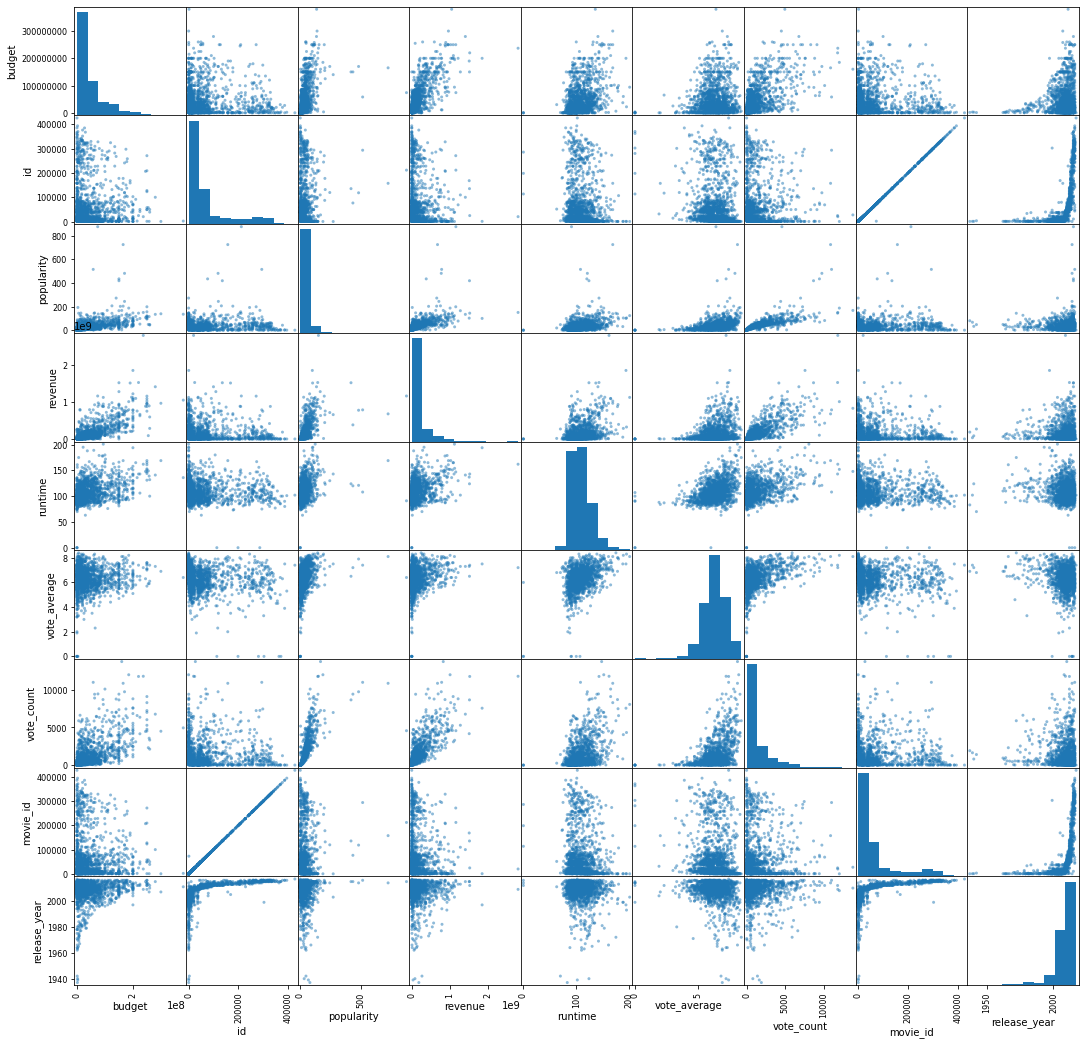

In [9]:
#eda plot scatter matrix
pd.plotting.scatter_matrix(df,figsize=(18,18));

In [12]:
df_nz=df[df['revenue']!=0]
df_nz=df_nz[df_nz['budget']!=0]
# df_nz is now defined for this section (nz for nonzero)
# the new dataframe has no zeros in the adjusted budget and revenue columns.
df_nz.shape

(1250, 26)

In [28]:
#kâr sütunu
def categorize_quartiles(df,column_label,bin_names):
    bin_edges=[
    df[column_label].describe()['min'],
    df[column_label].describe()['25%'],
    df[column_label].describe()['50%'],
    df[column_label].describe()['75%'],
    df[column_label].describe()['max']]
    categorized_column_label="categorized_"+column_label
    df[categorized_column_label]=pd.cut(df[column_label], bin_edges, labels=bin_names)
    return df

In [11]:
df["profit"] = df["revenue"] - df["budget"]

In [13]:
bin_names=['Big Loss','Loss','Medium Profit','High Profit']
df_nz=categorize_quartiles(df_nz,'profit',bin_names)
df_nz.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew,release_year,release_month,profit,categorized_profit
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.20,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009.00,December,2550965087,High Profit
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007.00,May,661000000,High Profit
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.38,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.00,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.30,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",2015.00,October,635674609,High Profit


In [25]:
df['main_genre']=df.genres.str[0]
df['leading_actor']=df.cast.str[0]
df['main_director']=df.crew.str[0]

In [29]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew,release_year,release_month,profit,main_genre,leading_actor,main_director
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.20,11800,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],2009.00,December,2550965087,Action,Sam Worthington,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],2007.00,May,661000000,Adventure,Johnny Depp,Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.38,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.00,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.30,4466,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],2015.00,October,635674609,Action,Daniel Craig,Sam Mendes
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.31,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.60,9106,49026,"[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],2012.00,July,834939099,Action,Christian Bale,Christopher Nolan
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.93,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.10,2124,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],2012.00,March,24139100,Action,Taylor Kitsch,Andrew Stanton


In [81]:
df_nz.groupby('categorized_profit').agg(lambda x:x.value_counts().index[0])['main_director']

categorized_profit
Big Loss           John Carpenter
Loss                  Kevin Smith
Medium Profit        Ridley Scott
High Profit      Steven Spielberg
Name: main_director, dtype: object

In [85]:
#türe göre kar
df_nz.groupby('categorized_profit').agg(lambda x:x.value_counts().index[0])['main_genre']

categorized_profit
Big Loss          Drama
Loss              Drama
Medium Profit    Comedy
High Profit      Action
Name: main_genre, dtype: object

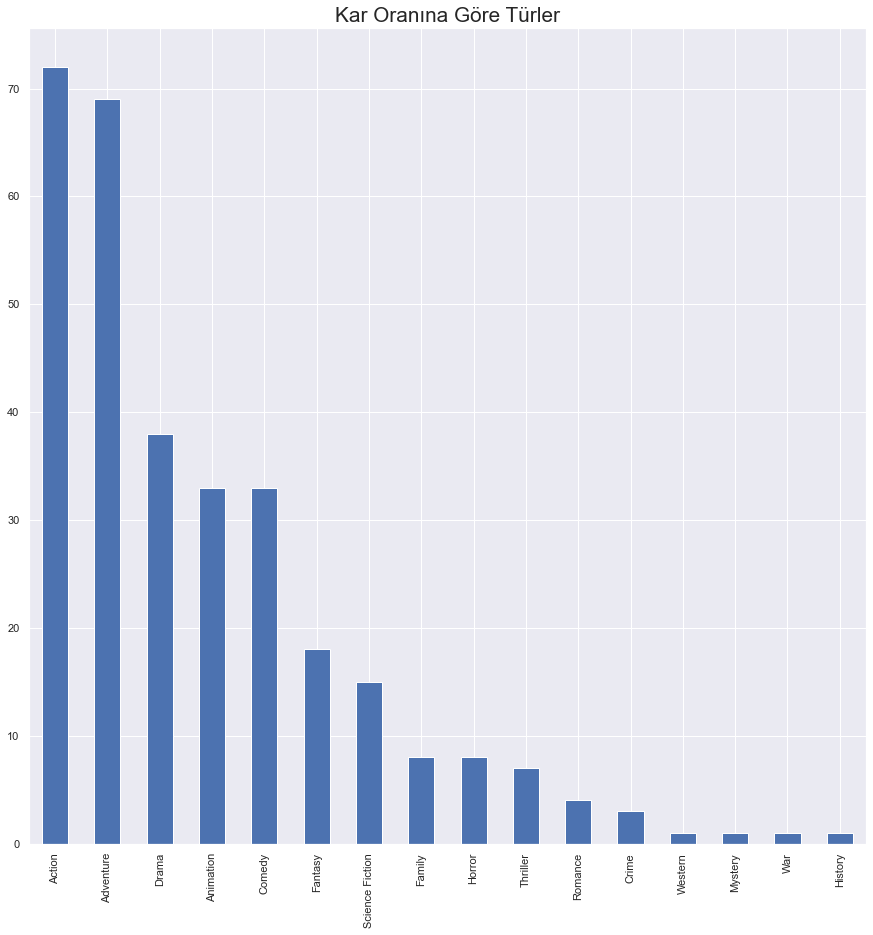

In [98]:
#en yüksek kara sahip tür chart ı
df_nz[df_nz['categorized_profit']=='High Profit']['main_genre'].value_counts().plot.bar(figsize=(15,15)).set_title("Kar Oranına Göre Türler",fontsize='xx-large');

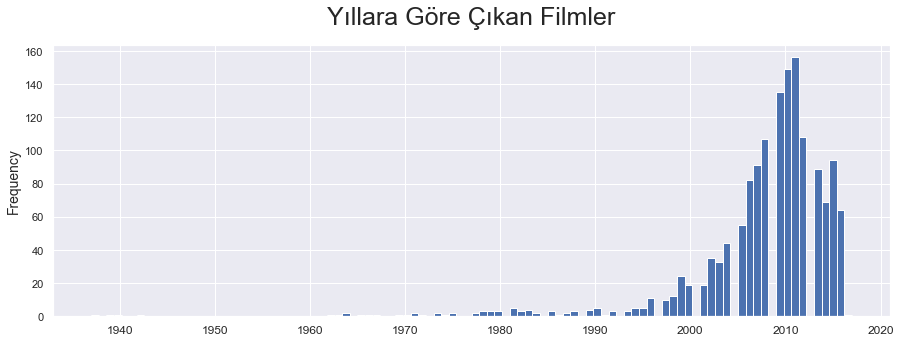

In [100]:
plt.xticks(fontsize=12)
plt.ylabel("Nb. of occurences", fontsize=14)
plt.title("Yıllara Göre Çıkan Filmler", fontsize=25, pad=20)
df["release_year"].plot.hist(figsize=(15,5), bins=100);

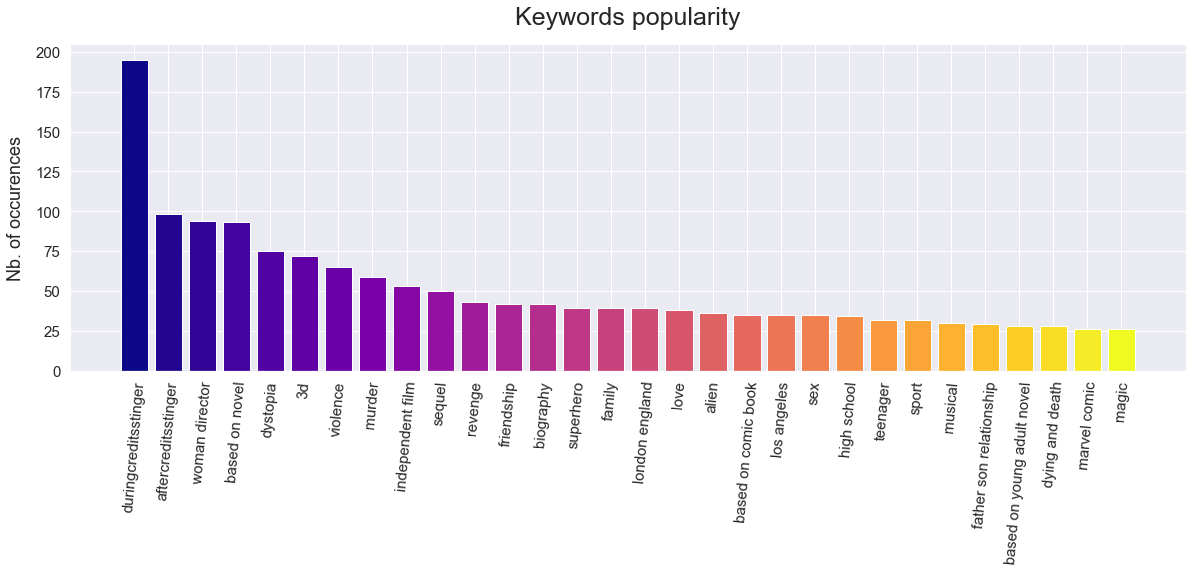

In [105]:
#Filmlerde en popüler keywordler
from collections import defaultdict, Counter
top_keywords_num = 30
keywords_flatten = sum(df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

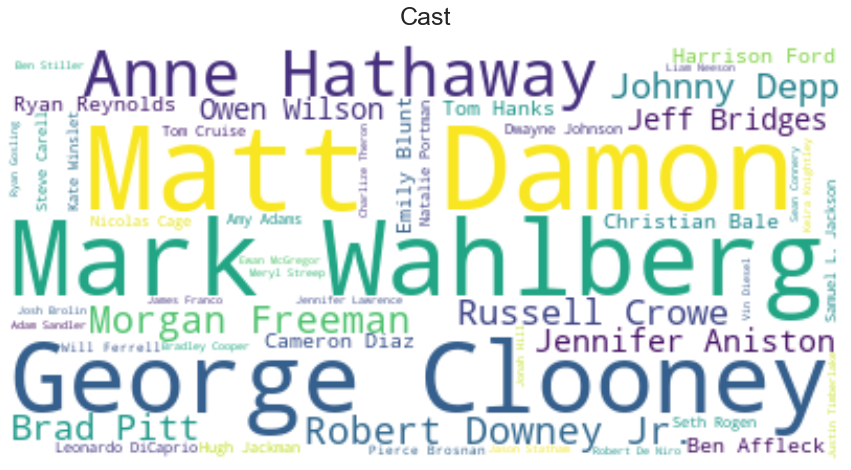

In [106]:
# plot unique cast frequency
cast_flatten = sum(df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

In [88]:
df['production_countries'] = df['production_countries'].apply(convert)
df['production_companies'] = df['production_companies'].apply(convert)


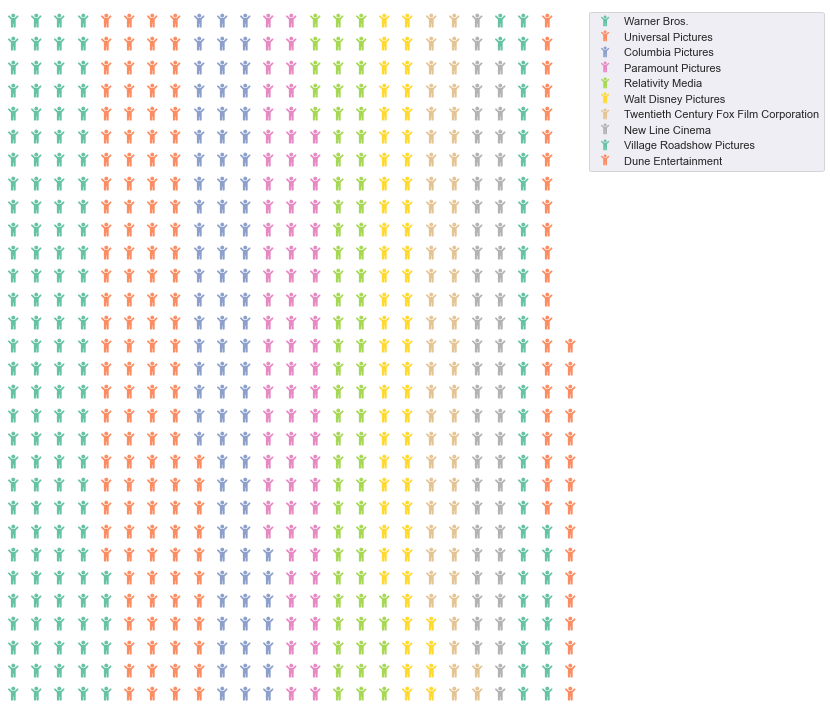

In [125]:
from pywaffle import Waffle
production_companies_flatten = sum(df["production_companies"].values, []) # production_companies are list of lists
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=dict(top_production_companies), 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', icon_size=14, 
    icon_legend=True,
    figsize=(20,10)
)

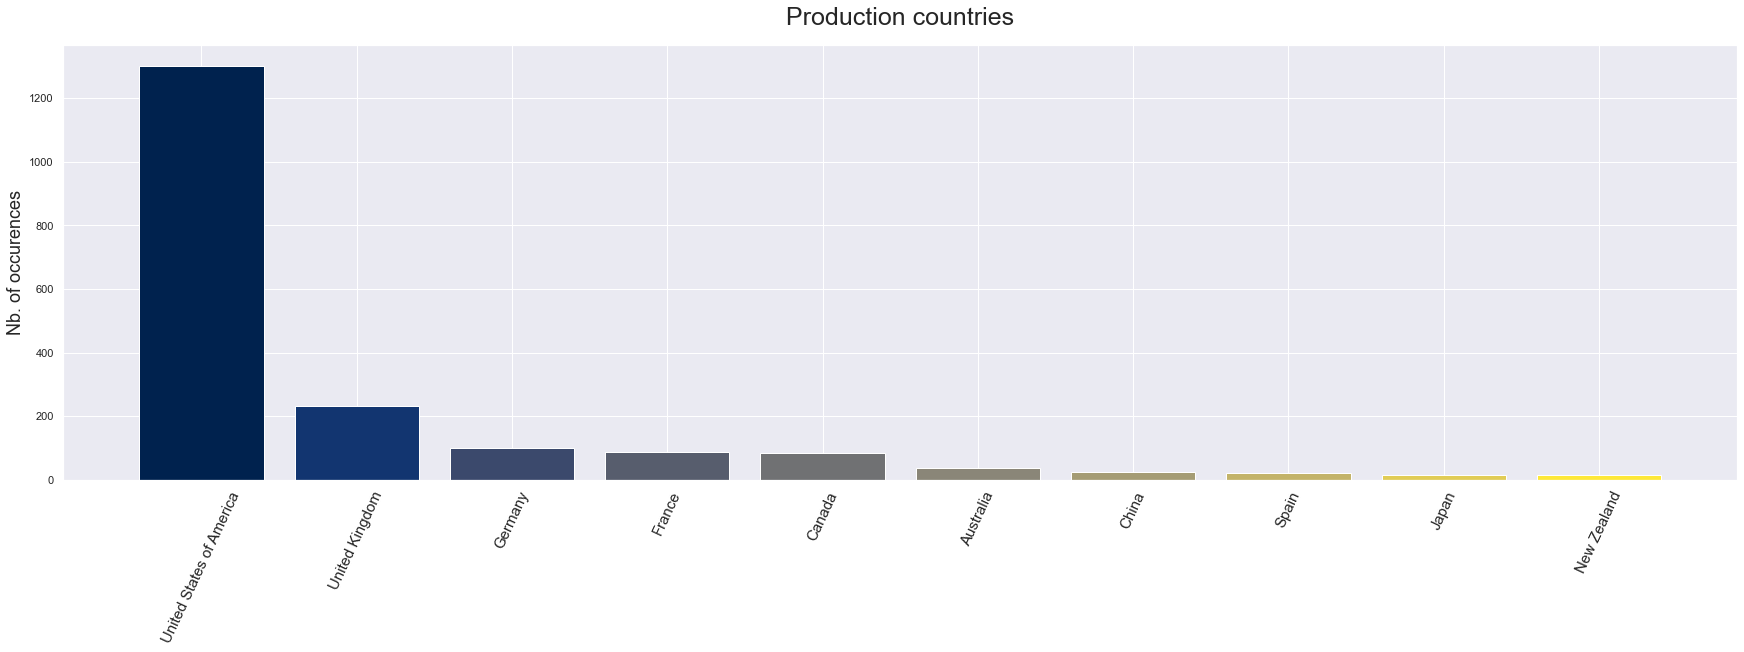

In [121]:
top_contries_num = 10
production_contries_flatten = sum(df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

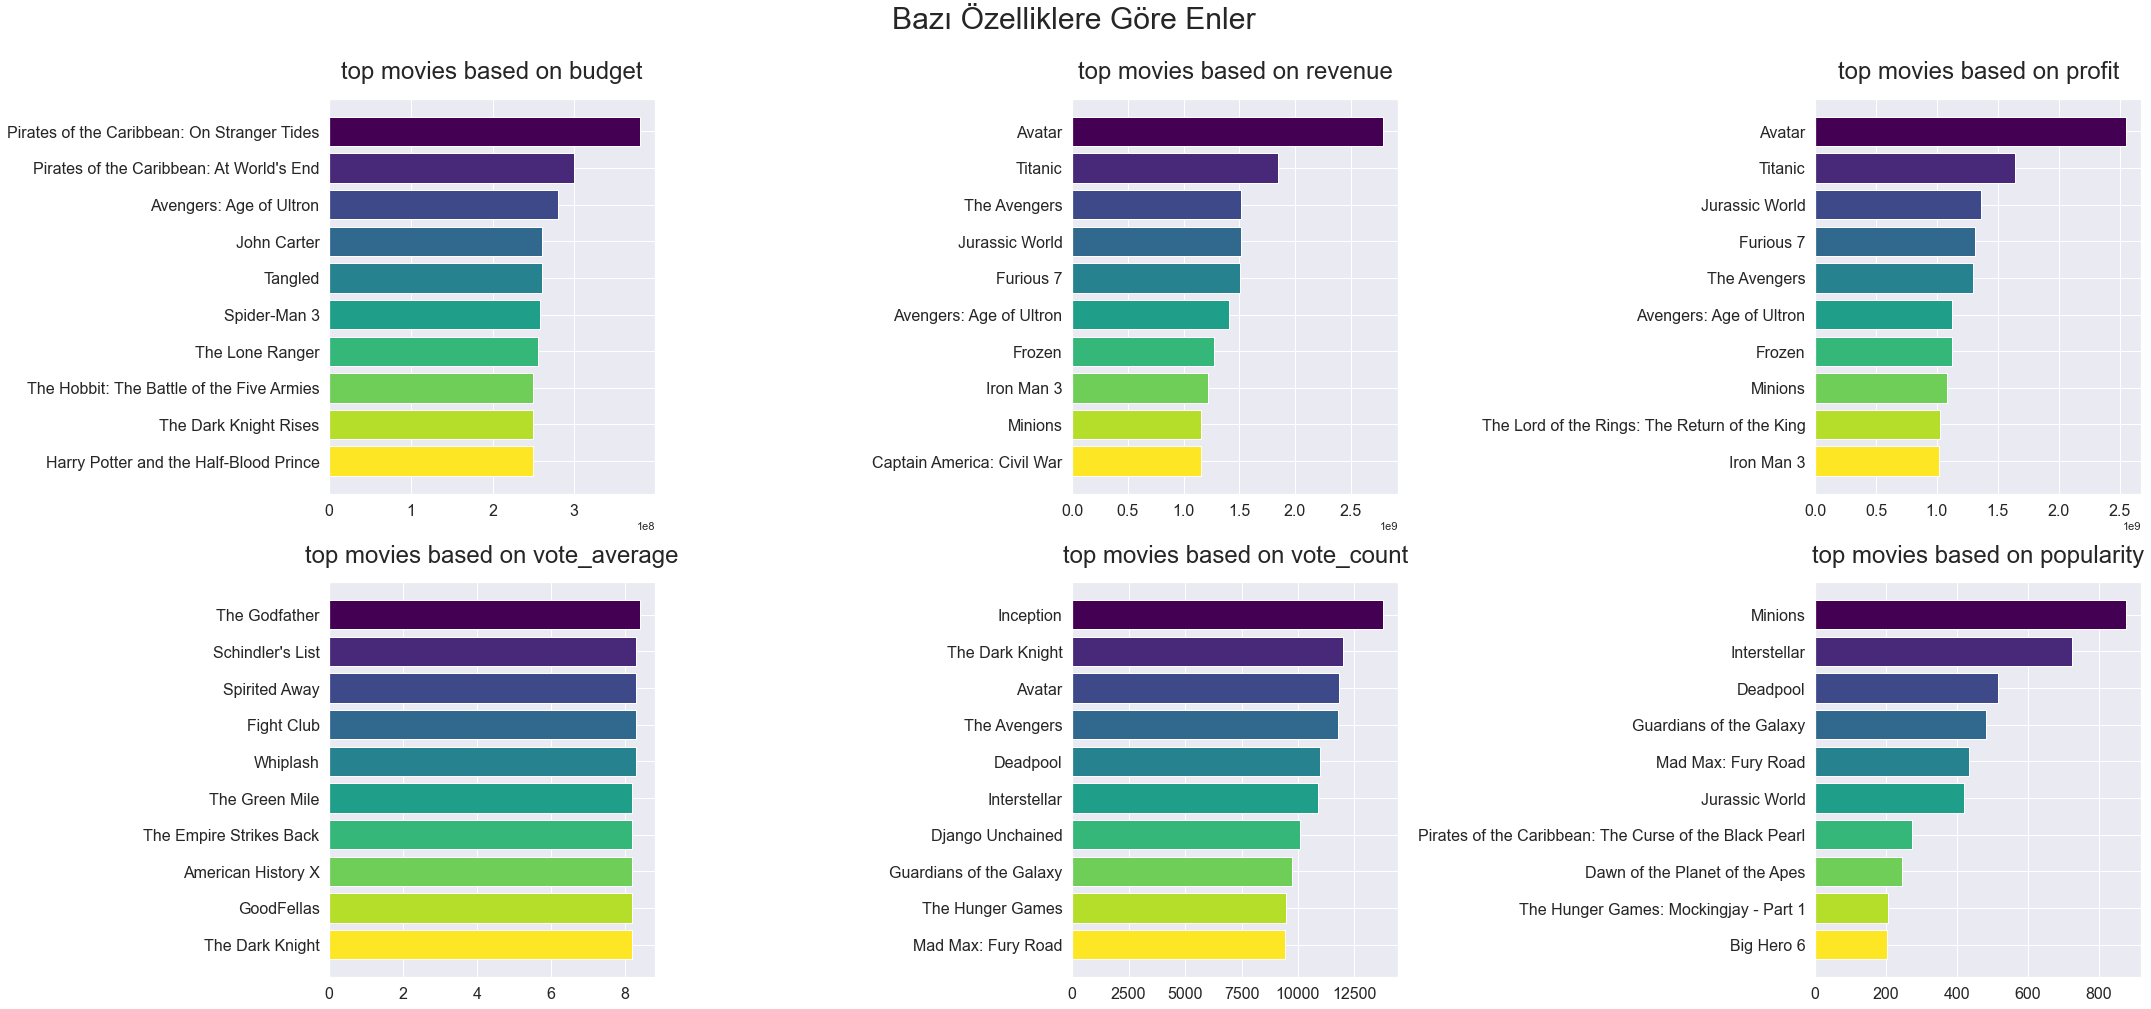

In [119]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Bazı Özelliklere Göre Enler',fontsize=30, y=1)
fig.tight_layout()

In [88]:
popularity_bin_names=['Not Popular','Somewhat Popular','Popular','Very Popular']
df=categorize_quartiles(df,'popularity',popularity_bin_names)
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew,release_year,release_month,profit,categorized_popularity,month,main_genre,leading_actor,main_director
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.20,11800,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],2009,December,2550965087,Very Popular,12,Action,Sam Worthington,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],2007,May,661000000,Very Popular,5,Adventure,Johnny Depp,Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,"[A, cryptic, message, from, Bond’s, past, send...",107.38,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.00,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.30,4466,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],2015,October,635674609,Very Popular,10,Action,Daniel Craig,Sam Mendes
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...",112.31,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.60,9106,49026,"[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],2012,July,834939099,Very Popular,7,Action,Christian Bale,Christopher Nolan
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"[John, Carter, is, a, war-weary,, former, mili...",43.93,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.10,2124,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],2012,March,24139100,Popular,3,Action,Taylor Kitsch,Andrew Stanton


In [89]:
import seaborn as sns

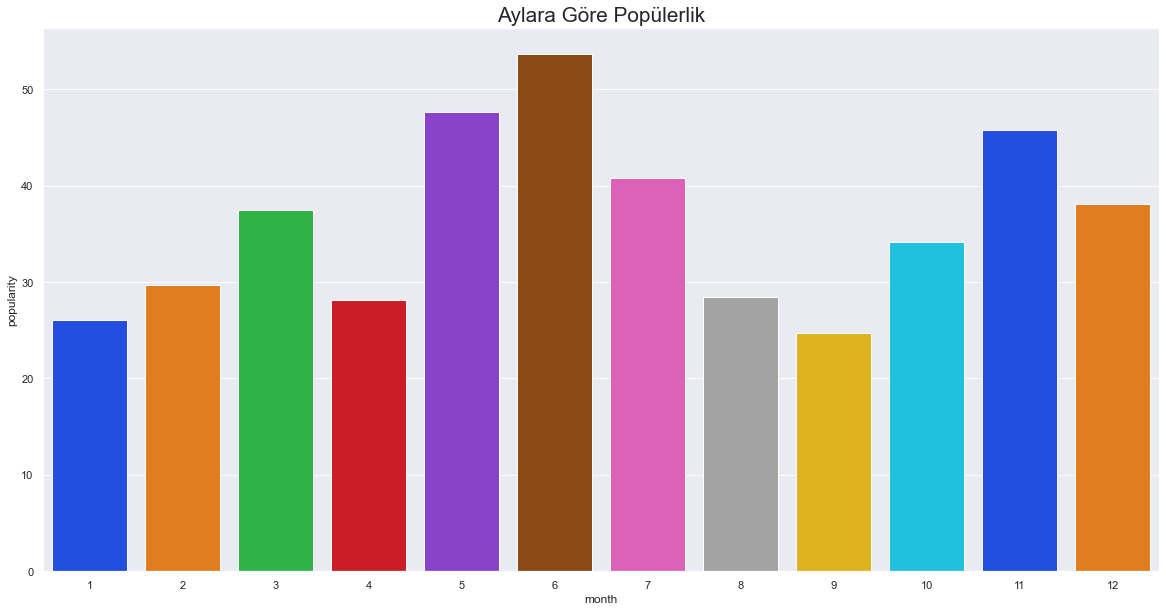

In [99]:
df['month'] = df['release_date'].dt.month
month_pop_mean=df.groupby('month')['popularity'].mean()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x=month_pop_mean.index, y=month_pop_mean, palette="bright").set_title("Aylara Göre Popülerlik",fontsize='xx-large');

In [95]:
df_nz.groupby('categorized_profit').agg(lambda x:x.value_counts().index[0])['main_director']

categorized_profit
Big Loss           John Carpenter
Loss                  Kevin Smith
Medium Profit        Ridley Scott
High Profit      Steven Spielberg
Name: main_director, dtype: object

In [96]:
high_profit_runtime_mean=df_nz[df_nz['categorized_profit']=='High Profit']['runtime'].mean()
print('The average runtime of a high profit movie is {} minutes'.format(int(high_profit_runtime_mean)))

The average runtime of a high profit movie is 119 minutes


In [ ]:
####After investigating which movies are more likely to have high or low profit we find that:

Steven Spielberg is the director with most movies that made high profit.
Renny Harlin is the director with most movies that were big losses.
The most frequent genre in high profit movies is action while the most fequent genre in losses is drama.
The majority of high profit movies are action, comedy, drama or adventure.
The average runtime of a high profit movie is 116 minutes.


After investigating which movies are more likely to be popular we find that:

Steven Spielberg is the director with most movies are very popular.
2015 and 2014 are the years with the highest average popularity score respectively
1966 is the year with the least average popularity score .
The middle of the year and the end of the year have the most popular movies.

In [16]:
import ast

In [198]:
#EDA
#Top 5 Movies

In [199]:
import requests
from IPython.display import Image, HTML, display
popular_movies = df.nlargest(n=5, columns=['popularity'])[['id', 'title']]
getList_name = {}
for x, xRows in popular_movies.iterrows():
    #print(xRows['id'])
    getResponse = requests.get('https://api.themoviedb.org/3/movie/{}?api_key=c0bda0be71f7815fd6ba2eb5f5c86fd8'.format(xRows['id']) )
    getData = getResponse.json()
    getPath = "http://image.tmdb.org/t/p/w500" + getData['poster_path']
    getList_name[xRows['title']] = getPath

display( HTML(f"""<table>
                    <tr>
                        <td><img src={list(getList_name.values())[0]} style='border-radius:10px; height:300px; width:575px; border:1px solid #999;'></td>
                        <td><img src={list(getList_name.values())[1]} style='border-radius:10px; height:300px; width:575px; border:1px solid #999;'></td>
                        <td><img src={list(getList_name.values())[2]} style='border-radius:10px; height:300px; width:575px; border:1px solid #999;'></td>
                        <td><img src={list(getList_name.values())[3]} style='border-radius:10px; height:300px; width:575px; border:1px solid #999;'></td>
                        <td><img src={list(getList_name.values())[4]} style='border-radius:10px; height:300px; width:575px; border:1px solid #999;'></td>
                    </tr>
                    <tr>
                        <td><div style="height:40px; padding-top:15px; text-align:center; font-size:14px; font-weight:bold; border:1px solid #ccc; border-radius:10px;">{list(getList_name.keys())[0]}</div></td>
                        <td><div style="height:40px; padding-top:15px; text-align:center; font-size:14px; font-weight:bold; border:1px solid #ccc; border-radius:10px;">{list(getList_name.keys())[1]}</div></td>
                        <td><div style="height:40px; padding-top:15px; text-align:center; font-size:14px; font-weight:bold; border:1px solid #ccc; border-radius:10px;">{list(getList_name.keys())[2]}</div></td>
                        <td><div style="height:40px; padding-top:15px; text-align:center; font-size:14px; font-weight:bold; border:1px solid #ccc; border-radius:10px;">{list(getList_name.keys())[3]}</div></td>
                        <td><div style="height:40px; padding-top:15px; text-align:center; font-size:14px; font-weight:bold; border:1px solid #ccc; border-radius:10px;">{list(getList_name.keys())[4]}</div></td>
                    </tr>
                </table>"""))

,,,,
Minions,Interstellar,Deadpool,Guardians of the Galaxy,Mad Max: Fury Road


In [17]:
#Data Preprocessing and cleaning
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L

In [18]:
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L 

In [19]:
#Vektörleştirme sırasında belli başlı şeyleri de ayrı ayrı almasın diye collapsa fonk. yazıcaz ki bitişik dursunlar. mesela isimler türler vs
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [49]:
#data visualization
tf = df['overview'].apply(lambda x : pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns=["words","tf"]
tf.sort_values("tf",ascending=False)

,words,tf
1,the,4137.00
0,a,2847.00
18,to,2506.00
7,and,2276.00
26,of,2143.00
...,...,...
8477,"jealous,",1.00
8480,tarnished,1.00
8482,"organisations,",1.00
8485,politics.,1.00


In [175]:
df.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,22nd century paraplegic marine dispatched moon...,"[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]


In [4]:
text = " ".join(x for x in df.overview)
wordcloud = WordCloud(max_font_size=50,
                     max_words=100,
                     background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud.png")

TypeError: sequence item 2662: expected str instance, float found

In [9]:
#feature engineering
#liste haline getirelim string leri ki ekleme işlemi yapabilelim
df['overview'] = df['overview'].apply(lambda x:x.split())

AttributeError: 'float' object has no attribute 'split'

In [10]:
df['tags'] = df['overview'] + df['genres'] + df['keywords'] + df['cast'] + df['crew']

In [213]:
new_df = df.drop(columns=["overview","genres","keywords","cast","crew"])

In [214]:
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

In [215]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [12]:
#################
df = movies.merge(credits,on='title')

In [13]:
#NLP teknikleriyle overview kısmını temizleme
df["overview"] = df["overview"].str.replace('[^\w\s]','')
df["overview"] = df["overview"].str.lower()
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')

df['overview'] = df['overview'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
#lemmetization
df['overview'] = df['overview'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [14]:
df = df[['movie_id','title','overview','genres','keywords','cast','crew']]

In [15]:
df.dropna(inplace=True)

In [20]:
df['genres'] = df['genres'].apply(convert)


In [21]:
df['keywords'] = df['keywords'].apply(convert)


In [22]:
df['cast'] = df['cast'].apply(convert)

In [23]:
df['cast'] = df['cast'].apply(lambda x:x[0:3])

In [24]:
df['crew'] = df['crew'].apply(fetch_director)


In [21]:
df['cast'] = df['cast'].apply(collapse)
df['crew'] = df['crew'].apply(collapse)
df['genres'] = df['genres'].apply(collapse)
df['keywords'] = df['keywords'].apply(collapse)

In [22]:
df['overview'] = df['overview'].apply(lambda x:x.split())

In [23]:
df['tags'] = df['overview'] + df['genres'] + df['keywords'] + df['cast'] + df['crew']

In [24]:
new_df = df.drop(columns=['overview','genres','keywords','cast','crew'])


In [25]:
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
cv = TfidfVectorizer(max_features=5000)

In [29]:
vector = cv.fit_transform(new_df['tags']).toarray()

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
similarity = cosine_similarity(vector)

In [34]:
similarity

array([[1.        , 0.02185281, 0.02997004, ..., 0.02165104, 0.00631066,
        0.        ],
       [0.02185281, 1.        , 0.02547308, ..., 0.02259762, 0.        ,
        0.        ],
       [0.02997004, 0.02547308, 1.        , ..., 0.02226197, 0.        ,
        0.        ],
       ...,
       [0.02165104, 0.02259762, 0.02226197, ..., 1.        , 0.01854761,
        0.02057374],
       [0.00631066, 0.        , 0.        , ..., 0.01854761, 1.        ,
        0.00677265],
       [0.        , 0.        , 0.        , ..., 0.02057374, 0.00677265,
        1.        ]])

In [246]:
def recommend(movie):
    index = new_df[new_df['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(new_df.iloc[i[0]].title)

In [313]:
import pickle
pickle.dump(new,open('movie_list.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))